# Coursework for Cardiac MR Image Segmentation (2021-2022)


## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [ ]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0 233 226 221 205 222
 156  84 101 187 180 201 138 153  29 143 107 143 102  53   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


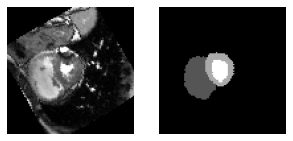

True

In [ ]:
import os
import cv2 #import OpenCV
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/Colab Notebooks/CW/data"
train_data_dir = path + '/train'
val_data_dir = path + '/val'
test_data_dir = path + '/test'

image = cv2.imread(os.path.join(train_data_dir,'image','cmr300.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(train_data_dir,'mask','cmr300_mask.png'), cv2.IMREAD_UNCHANGED)
print(image[0])
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr201.png'), mask*85)

## 1.1 Creating more **images** with Data Augmentation

In [ ]:
#import libraries needed for data augmentation
import elasticdeform
import random

In [ ]:
#perform augmentation
for t in range(1,10):
    for i in range(1,101):
        image = cv2.imread(os.path.join(train_data_dir,'image','cmr'+str(i)+'.png'), cv2.IMREAD_UNCHANGED) #reading image
        mask = cv2.imread(os.path.join(train_data_dir,'mask','cmr'+str(i)+'_mask.png'), cv2.IMREAD_UNCHANGED) #reading mask
        #randomly adding deformations
        [image_deformed, mask_deformed] = elasticdeform.deform_random_grid([image, mask],sigma=random.randrange(0,5),order=0,rotate=random.randrange(-270,270),zoom=round(random.uniform(0.8,1.5),2))
        cv2.imwrite(os.path.join(train_data_dir,'mask','cmr'+str(1100+i+100*(t-1))+'_mask.png'),mask_deformed) #saving deformed image
        cv2.imwrite(os.path.join(train_data_dir,'image','cmr'+str(1100+i+100*(t-1))+'.png'),image_deformed) #saving deformed mask

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

In [ ]:
import torch
import torch.utils.data as data
import os
from glob import glob

In [ ]:
#define dataloaders
class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class ValDataset(data.Dataset):
    def __init__(self, root=''):
        super(ValDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            
    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), img_path

    def __len__(self):
        return len(self.img_files)

In [ ]:
#checking if gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

The current device is cpu


### 2.2 Define a Segmenatation Model

Defining a Unet Model with 24 layers and depth of 4 for Segmentation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


#Defining model based on UNet architecture
class UNET2(nn.Module): 
    def __init__(self):
        super(UNET2, self).__init__()
        initial_conv_value = 64
        #first conv layer takes 1 input channel and outputs activation map with 64 channels
        self.conv_input_layer0 = nn.Conv2d(1, inz, 3, padding=1)
        self.conv_layer0_layer0 = nn.Conv2d(64 ,64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)

        #we define all our non-linear activations to use ReLu
        self.nonlinear = nn.ReLU()

        #define remaining conv layers
        self.conv_layer0_layer1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv_layer1_layer1 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv_layer1_layer2 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv_layer2_layer2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv_layer2_layer3 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv_layer3_layer3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv_layer3_layer4 = nn.Conv2d(512, 1024, 3, padding=1)
        self.conv_layer4_layer4 = nn.Conv2d(1024, 1024, 3, padding=1)

        #define deconv layers to get original input size back for output
        self.deconv_layer4_layer3 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv_layer4_layer3 = nn.Conv2d(1024, 512, 3, padding=1)
        
        self.deconv_layer3_layer2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv_layer3_layer2 = nn.Conv2d(512, 256, 3, padding=1)
        
        self.deconv_layer2_layer1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv_layer2_layer1 = nn.Conv2d(256, 128, 3, padding=1)
        
        self.deconv_layer1_layer0 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv_layer1_layer0 = nn.Conv2d(128, 64, 3, padding=1)
        
        #final output layer outputs an image with 4 channels
        self.conv_layer0_output = nn.Conv2d(64, 4, 1)
        
    def forward(self, x):
        
        #define forward propagation steps
        x_0 = self.nonlinear(self.conv_layer0_layer0(self.nonlinear(self.conv_input_layer0(x))))
        x_1 = self.pool(x_0)
        
        x_1 = self.nonlinear(self.conv_layer1_layer1(self.nonlinear(self.conv_layer0_layer1(x_1))))
        x_2 = self.pool(x_1)
        
        x_2 = self.nonlinear(self.conv_layer2_layer2(self.nonlinear(self.conv_layer1_layer2(x_2))))
        x_3 = self.pool(x_2)
        
        x_3 = self.nonlinear(self.conv_layer3_layer3(self.nonlinear(self.conv_layer2_layer3(x_3))))
        x_4 = self.pool(x_3)
        
        x_4 = self.nonlinear(self.conv_layer4_layer4(self.nonlinear(self.conv_layer3_layer4(x_4))))
        
        x_3_up = self.deconv_layer4_layer3(x_4)
        x_3 = torch.cat((x_3, x_3_up), 1)
        x_3 = self.nonlinear(self.conv_layer3_layer3(self.nonlinear(self.conv_layer4_layer3(x_3))))
        
        x_2_up = self.deconv_layer3_layer2(x_3)
        x_2 = torch.cat((x_2, x_2_up), 1)
        x_2 = self.nonlinear(self.conv_layer2_layer2(self.nonlinear(self.conv_layer3_layer2(x_2))))
        
        x_1_up = self.deconv_layer2_layer1(x_2)
        x_1 = torch.cat((x_1, x_1_up), 1)
        x_1 = self.nonlinear(self.conv_layer1_layer1(self.nonlinear(self.conv_layer2_layer1(x_1))))
        
        x_0_up = self.deconv_layer1_layer0(x_1)
        x_0 = torch.cat((x_0, x_0_up), 1)
        x_0 = self.nonlinear(self.conv_layer0_layer0(self.nonlinear(self.conv_layer1_layer0(x_0))))
            
        x = self.conv_layer0_output(x_0)
     
        return x

#instantiate model and transfer to gpu (if available)
model = UNET2().to(device) 

### 2.3 Define a Loss function and optimizer


In [ ]:
import torch.optim as optim

#hyperparammeters for optimiser
learning_rate = 0.0002
betas = (0.9, 0.99)
wgts = [0.1, 0.3, 0.3, 0.3]

#weights for loss function
weights = torch.tensor(wgts).to(device)

#define loss and optimiser
Loss = nn.CrossEntropyLoss(weight=weights)
Loss.requires_grad_(True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=betas)

### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [ ]:
from torch.utils.data import DataLoader
import numpy as np

# get the model
model = model.to(device)

# define parameters for training 
num_workers = 4
batch_size = 25
max_epochs = 50

# seed generator for worker 
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

# add 2 params in the fn worker_init_fn=seed_worker, generator=g
train_set = TrainDataset(train_data_dir)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, worker_init_fn=seed_worker, generator=g, shuffle=True)

# define vars to store epoch stats
epochs = [x for x in range(1, max_epochs+1)]
running_loss = 0.0
final_loss = []

 
for epoch in range(max_epochs):
    
    # Fetch images and labels. 
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample

        model.train() #put model in train mode
        optimizer.zero_grad() #set gradients to zero to avoid accumulating them
        
        #Get image in correct format and transfer to gpu (if available)
        image_for_model = torch.unsqueeze(img, 1).to(device)

        #pass image through network and get output using forward propagation
        predicted_mask = model(image_for_model).to(device)
        
        #calculate the loss usinde loss function defined above
        loss = Loss(predicted_mask, mask.long().to(device))
   
        #Do backward proagation and step through with optimiser to update network parameters
        loss.backward()
        optimizer.step()
        
        #calculate running loss
        running_loss += loss.item()
   
        value, predicted_mask_image = torch.max(predicted_mask, 1)
    print('[%d, %5d] loss: %.3f' %(epoch + 1, iteration + 1, running_loss/(iteration+1))) #print loss for epoch
    final_loss.append(running_loss) #computing final loss for plotting
    running_loss = 0.0

#visualise final predicted mask passed through network     
show_image_mask(img[0,...].squeeze().cpu(), mask[0,...].squeeze().cpu())
show_image_mask(img[0,...].squeeze().cpu(), predicted_mask_image[0,...].squeeze().cpu())
plt.pause(1)

#save the model
torch.save(model.state_dict(), "./tensor.pth")

# plot loss graph
plt.plot(epochs,final_loss)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### 2.5 Validating and Testing

Using the Categorical Dice Loss in order to check the validation set accuracy.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [ ]:
#Validating model on Validation Set

#set parameters
num_workers = 4
batch_size = 1

#load validation images
val_set = ValDataset(val_data_dir)
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

#load saved model and set to eval model
model = UNET2()
model.load_state_dict(torch.load("./tensor.pth"))
model.eval()

#loss variables
avg_loss = 0
dice_loss = 0
total_dice_loss = 0

#var to keep track of number of iterations
i = 0

with torch.no_grad():
    for iteration, sample in enumerate(val_data_loader):

        dice_loss = 0
        img, mask = sample
        img = img.unsqueeze(1)

        #get predicted mask using model
        outputs = model(img)

        #calculate estimated categorical dice loss for each class and average
        _, predicted = torch.max(outputs, 1)
        dice_loss += categorical_dice(mask.numpy(), predicted.numpy(), 1)
        dice_loss += categorical_dice(mask.numpy(), predicted.numpy(), 2)
        dice_loss += categorical_dice(mask.numpy(), predicted.numpy(), 3)
        dice_loss /= 3
        total_dice_loss += dice_loss

        #visualise predicted and true mask
        # show_image_mask(img[0,...].squeeze(), mask[0,...].squeeze(), cmap='gray')
        # show_image_mask(img[0,...].squeeze(), predicted[0,...].squeeze(), cmap='gray')    
        
        i += 1

#calculate dice loss average over all validation examples
total_dice_loss = total_dice_loss / i

#print loss
print("Categorical Dice Loss: ", total_dice_loss)

In [ ]:
# Predicting the mask images for test data set and storing in a directory

# parameters
num_workers = 0
batch_size = 1

# load test data
test_set = TestDataset(test_data_dir)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

# load saved model
model = UNET2().to(device)
model.load_state_dict(torch.load("./tensor.pth"))
model.eval()

for iteration, (sample, path_name) in enumerate(test_data_loader):

    img_number = str(path_name).split("cmr")[-1].split(".")[0]

    img = sample
    img = img.unsqueeze(1).to(device)

    #get predicted mask
    outputs = model(img).to(device)
    _, predicted = torch.max(outputs, 1)

    #get predicted mask to save as numpy array
    npi = predicted[0].cpu().numpy()
  
    #define name of png file to save predicted mask as
    file_name = 'cmr' + img_number + '_mask.png'
  
    #save png file
    cv2.imwrite((test_data_dir + "/mask/" + file_name), npi)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()

#call function to submit our images
submission_converter(test_data_dir + '/mask', test_data_dir)

#Introduction 

The task we are attempting is to segment cardiovascular magnetic resonance (CMR) images into four regions: the background, left ventricle, myocardium and right ventricle. We’ll be using semantic segmentation to do this, which assigns a label to all the pixels in an image, where pixels that share characteristics will have the same label. To perform this task we will be constructing a convolutional neural network (CNN). The dataset we are using is a modified version from the ACDC<sub>1</sub> challenge. It contains 200 CMR images and corresponding segmented masks. The dataset will be split 50%, 10% and 40% for training, validation and testing respectively. During this experiment, we will to explore a variety of CNN architectures and hyperparameters in order to implement a neural network which can accurately segment cardiovascular MR images.  



#Implementation  <sub>2</sub>

The model currently employed is the U-net architecture. U-net is a fully convolutional neural network with a symmetric architecture, hence the U-shape. It consists of two major parts — the left part is called contracting path, which is constituted by the general convolutional process; the right part is an expansive path, which is constituted by transposed 2D convolutional layers. In the contracting path, the network learns important features and in the expansive path tries to enhance the resolution of the image to bring it to the original size of the image. In the contracting path U-net uses max pooling layers to decrease the size of the image and in the expansive path it replaces the max pooling layers with deconvolution layers to amplify small features. The same idea is also adopted in DeepLab to enhance the resolution <sub>3</sub>. The fully connected layers are also removed so that small changes in regions where the main object occurs does not affect the prediction.
The main reason for going forward with this architecture was due to the fact that U-net has a major role in medical image segmentation, which coincides with our task. The only difference in our proposed architecture is that we add padding in every convolution layer unlike the original network where the borders are cropped.
In our network we apply two 3 x 3 convolutions (padding =1) each succeeded by a ReLU. Then we apply 2 x 2 maxpooling operation with a stride of 2. After every maxpooling the feature channels are doubled. The above combination is applied 4 times until we reach an image of dimensions 6 x 6 x 1024 after which we apply a convolution + ReLU twice. In the expansive path we upsample the data and we concatenated with the corresponding feature map. Then again, we apply two 3 x 3 convolutions each succeeded by ReLU, hence obtaining a symmetric architecture. The feature maps are halved every time we upsample the data. The expansive step is applied until we reach a feature map of size 96 x 96 x 64. Finally, we apply a 1 x 1 convolution that maps each feature vector to the 4 classes. The below figure illustrates our architecture:





<figure>
<center>
<img src='https://drive.google.com/uc?id=12jyIfYwbRnS2XlMeLLDTSLDCVM-0p2H2' />
</figure>

Initially we research a variety of CNNs, looking at both academic papers and online articles, in order to get a broad understanding of them and how their different architectures may impact the result of the model. From our research and implementations, we found that architectures which have many layers such as DeconvNet and Deeplab both produced bad results primarily due to the fact we have a small dataset, which leads to overfitting while training the model. Despite initial concerns about lack of computational power, we found that SegNet produced good results. However, we decided to use UNet as it produced the best results from our initial experiments, and our research found that it is the best architecture to use when working with low volumes of data <sub>4</sub>.

##Loss functions considered:
The main idea of all loss functions and optimizers is to determine the point where the function is the minimum. However, most algorithms take the assumption that the function is convex. Below we detail the different loss functions we considered using for training. 
###Lovasz Softmax:
Lovasz Softmax is based on the idea of Lovasz hinge and this method assumes that we are dealing with a convex function. As a result, if the function is not convex, we would not be able to find the global minima and may get stuck in a local minimum <sub>5</sub>.
###Dice Loss:
Dice loss uses the Dice coefficent to calculate the overlap between two images. It is computed using the following formula:

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

*where A and B are images.* <sub>6</sub>
###Focal Loss:
Focal loss builds on standard cross-entropy loss, such that loss can be calculated using:
$FL(p$<sub>t</sub>$)=(1-p)$<sup>$γ$</sup>$log(p$<sub>t</sub>$)$

Adding the factor $(1-p)$<sup>$γ$</sup> reduces the weighting of well classified examples. This means that misclassfied examples have a greater impact of the overall loss.<sub>7</sub>

###Boundary Loss:
Boundary loss uses distance metric on space contours rather than segmentation regions that other losses such as Dice or Cross-entropy use. Using integrals over the interface of regions enables it to work well on highly unbalanced problems. <sub>8</sub>

##Loss function implemented:
###Cross-Entropy:
Cross entropy is based on the concept of entropy in information theory and is different from KL Divergence (i.e Kullback Leibler Divergence), which calculates the relative entropy between two probability distributions. Cross-entropy loss deals with finding the total entropy between the distributions. This is represented by taking the negative log-likelihood where the increased negative value indicates a higher loss. We have intuitively understood that in order to really evaluate which classes (3 channels) of the image data are correctly or not correctly predicted, a loss function that deals with categorical data would be the best choice. <sub>9</sub>

##Optimizers considered:   <sub>10</sub>

###Stochastic Gradient Descent:
SGD randomly picks one data point from the whole data set at each iteration to reduce the computations enormously.
It is also common to sample a small number of data points instead of just one point at each step and that is called “mini-batch” gradient descent. Mini-batch tries to strike a balance between the goodness of gradient descent and speed of SGD.

###AdaGrad:
Adagrad is an adaptive learning rate method. In Adagrad we adapt the learning rate to the parameters. We perform larger updates for infrequent parameters and smaller updates for frequent parameters. It is well suited when we have sparse data as in large scale neural networks. In Adagrad, we use different learning rates for every set of parameters for each time step.

##Optimizer implemented : <sub>10</sub>
###Adam:
Adam is another method that calculates the individual adaptive learning rate for each parameter from estimates of first and second moments of the gradients.It also reduces the radically diminishing learning rates of Adagrad. Adam can be viewed as a combination of Adagrad, which works well on sparse gradients and RMSprop which works well in online and nonstationary settings. It implements the exponential moving average of the gradients to scale the learning rate instead of a simple average as in Adagrad. It keeps an exponentially decaying average of past gradients. Adam is computationally efficient and has very little memory requirement. Adam optimizer is one of the most popular gradient descent optimization algorithms.
Hyper-parameters β1, β2 ∈ [0, 1] control the exponential decay rates of these first and second moments.






#Experiment

##Data augmentation:
One of our biggest concerns while constructing this model was the limited dataset as it can be difficult to get high accuracy. When using the original 100 MR images for training our best result has a loss of 0.008 when training the model and validation results around 0.857. In order to improve the results of the model, we used data augmentation. Initially, we had just rotated the images, but later found there we could manipulate the images in other ways. For example, using a library called elastic deform we were able to create images similar to the original dataset by changing the standard deviation parameter. The aim of only going down to 0.8 with zooming was to try and decrease the overall prevalence of the background class, as the other classes are mostly centered. We were able to create 1900 extra images through randomised zooming, sigma and rotation of 0.8-1.5, 0-5 and -270 to 270 degrees respectively. Through data augmentation, we were able to increase validation accuracy by 0.02 overall. 


##Loss functions:
All of the experiments regarding loss functions and optimizers were conducted on the original dataset provided.

###Dice Loss, Boundary Loss and Focal Loss:

Dice, Boundary and Focal loss all required vectors with a single channel, whereas our model had 4 output channels. We attempted to expand it to a multiclass problem for Dice loss, where we computed Dice per-channel and then averaged over channels and batch to get the mean Dice per-class. This approach didn’t seem to entirely fit into our data as we want to see the overall performance of the channels rather than see an averaged version of the channel outputs. Therefore, we concluded that these loss functions wouldn't work for our model. 

However, we still chose to use categorical dice loss as a metric to evaluate the validation loss as that is the metric used for testing. 

###Lovasz Softmax:
The loss values obtained in using Lovasz Softmax for our model is as given below:

Epoch | Training Loss | Validation loss
---| --- | ---
100 | 0.269 | 0.77
150 | 7.224|0.1

Although Lovasz Softmax worked well for 100 epochs, it eventually ended up giving a higher training loss when run for 150 epochs. Although this has given a smaller validation loss, this may simply be that the validation set may be an ideal reflection of the training set. This may also indicate that the loss value is stuck at a local minimum instead of a global minima as we cannot assure that the function that best fits our model is convex. Taking these points into consideration, Lovasz Softmax did not seem to be a reliable loss function for our dataset and model.


###Cross Entropy:

The next loss which was experimented with was using weighted and non-weighted cross entropy. The weights were set manually by intuition from data.
The training losses for different values of weights with cross entropy with various epochs is as illustrated below:

Weight values | Epochs | Training Loss | Validation Loss 
---| --- | --- | --- |
No weights | 100 | 0.036 | 0.80
Calculated using frequency of class in training masks | 100 | 0.018 | 0.61
[0.1, 0.3, 0.3, 0.3] | 100 | 0.068 | 0.71
[0.1, 0.3, 0.3, 0.3] | 130 | 0.163 | 0.735
[0.15, 0.3, 0.35, 0.35] |150 | 0.018 | 0.85
[0.2, 0.35, 0.35, 0.35] | 150 | 0.058 | 0.81
Automatically calculated weights within loss function | 70 | 0.078 | 0.76

We gave lower weight to class 0 (the background) in order to prioritise the foreground and ensure we highlight the importance of training the foreground to match as well as possible. 
Class 1 has slightly lower weight to the other two as the overall average frequency of pixels of class 2 was lower in training masks.
Using these manual weights meant that the model took longer to converge but gave a higher validation loss overall. 

After doing this initial testing, we created more data points and did the same tests, in the end obtaining a slightly different result. We decided to write code that can extract the exact ratio of classes from the data points, and we got results that did fit our own prediction following testing on augmented data, with the optimum weights being: [0.1, 0.3, 0.3, 0.3].

###Optimizers:

After iterative experiments it was clear that cross entropy would be the loss function to be employed in our model. The next step was to select the optimizer function.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1yqdP-eZL-A4AwohdkDkzBnYjUpCBSJbw' />
</figure>


The above diagram shows the comparison of various optimizers on MNIST dataset Training a Multilayer Perceptron <sub>11</sub> .
Looking at the overall performance and working mechanism of optimizers, the experiment was run by taking the following three optimizers:


####Stochastic Gradient Descent:

We conducted experiments on various hyperparameters for Stochastic Gradient Descent (SGD), such as the batch size, epochs, learning rate and more. Using a batch size of 10 produced the best results when using a training set of 100 images. A batch size lower than 10 resulted in high fluctuation in the training loss and the model didn’t learn quickly enough when the batch size is greater than 10, resulting in a lower validation accuracy. 

Momentum |Learning Rate | Batch Size | Epochs| Training Loss | Validation Accuracy |
---| --- | --- | --- | --- | --- |
0.8 | 0.001 | 5 | 200 | 0.265 | 0.482
0.8|0.001|5|500|0.099|0.675
0.99 |0.001 |10 |400 |0.020 |0.760
0.99 | 0.001 |10 | 500 |0.013 |0.788


We found that 0.99 momentum gave the best validation accuracy with the highest being 0.788. When the moment was decreased to 0.8 the model produced significantly worse results, with the validation accuracy being 0.494 worse than when the moment was 0.99 and all other parameters consistent. A momentum of 0.999 caused the loss to diverge and often resulted in unreadable results. If the readable results were produced then the loss was extremely large and validation accuracy quite low. For example, 0.999 momentum, 0.001 learning rate, batch size of 10 and a 100 epochs produced a training loss of 0.516 and accuracy of 0.26. Using learning rates larger than 0.001, such as 0.01 and 0.005, also produced unreadable results. 

Momentum |Learning Rate | Batch Size | Epochs | Training Loss | Validation Accuracy |
---| --- | --- | --- | --- | --- | 
0.999 | 0.001 | 10 | 100 | 0.516 | 0.26
0.999 | 0.001 | 10 | 200| NaN | ----
0.999 | 0.001 |10 | 300 |NaN |----
0.99 |0.001 |10 |500 |0.032 |0.788
0.99 |0.01 |10 |200 |NaN |----
0.99 | 0.005 | 10 | 20 | NaN |----


As this was run on the original training set, we found a large number of iterations needed to be run, with 500 epochs producing the highest validation accuracy. We also found that using Nesterov momentum doesn’t improve validation accuracy or training loss. 

####AdaGrad:

Learning Rate | Batch Size | Iterations |Training Loss |Validation Accuracy
---| --- | ---| ---| ---
0.001|10|200|0.041|0.734|
0.001|10|400|0.056|0.753
0.001|10|500|0.028|0.740
0.001|20|200|0.062|0.664
0.001|20|400|0.017|0.698

Compared to the other optimizer, AdaGrad produced the worst results, with the highest validation score of 0.753 being achieved when using a learning rate of 0.001, batch size of 10 and 400 epochs. 

####Adam:

When experimenting with the number of epochs we found that until 200 epochs, an increase in epochs resulted in greater accuracy and lower loss. However, after 200 epochs there was a stagnation in that accuracy. We also observed that the larger the learning rate, the faster the model would converge and the training loss didn’t fluctuate as much. Despite this, a learning rate above 0.0005 caused a decrease in validation accuracy. 

Betas|Learning Rate|Batch Size|Epochs|Training Loss|Validation Accuracy
---|---|---|---|---|---|
(0.9,0.999)|0.0002|10|50|0.051|0.749
(0.9,0.999)|0.0002|10|100|0.030|0.784
(0.9,0.999)|0.0002|10|200|0.016|0.836
(0.99,0.999)|0.0005|10|50|0.116|0.668
(0.99,0.999)|0.0005|10|100|0.026|0.801
(0.99,0.999)|0.0005|10|200|0.016|0.801
(0.9, 0.99)|0.0005|10|30|0.083|0.782
(0.9, 0.99)|0.0005|10|50|0.041|0.826
(0.9, 0.99)|0.0001|10|30|0.330|0.612
(0.9, 0.99)|0.0001|10|50|0.065|0.687

We found that when the 2nd beta is 0.999, the model becomes unstable. Initially. the training loss value decreases as expected but then suddenly increases. This can be seen below as the training loss is 4770405.5 and accuracy is 0.101. On some occasions, the loss will converge back after suddenly increasing. We found that if we are using a high number of iterations this phenomenon can repeat multiple times. 

Betas|Learning Rate|Batch Size|Epochs|Training Loss|Validation Accuracy
---|---|---|---|---|---|
(0.9,0.999)|0.001|10|50|0.095|0.665
(0.9, 0.999)|0.001|10|200|0.013|0.822
(0.9, 0.999)|0.001|10|400|0.139|0.463
(0.9, 0.999)|0.001|10|500|4770405.5|0.101


When using Nesterov momentum, we observed it produced bad results as it caused the training loss to fluctuate a lot. This can be seen when we also observed that if the loss was above 0.1, it would result in low accuracy regardless of the hyperparameters the optimizer was using. If the loss was below 0.04, we found that the model was overfitting to the training data. 

Betas|Learning Rate|Batch Size|Epochs|Nesterov Momentum|Weight Decay|Training Loss|Validation Accuracy
---|---|---|---|---|---| --- | --- |
(0.9, 0.99)|0.001|10|100|Yes|0.004|0.433|0.005
(0.9, 0.99)|0.001|10|200|Yes|0.004|NaN|---
(0.9, 0.99)|0.001|10|400|Yes|0.004|NaN|---


In comparison with other optimizers, we found Adam performed the best with the top result being an accuracy of 0.857 and training loss of 0.008. Therefore, we decided to use Adam as the optimizer for our model. 

###Adam with augmented data:
From our earlier experiments, we concluded that Adam outperformed the other optimizers. The results below show results from experiments where we are determining the best hyperparameters for the optimizer functions when using augmented data.

Due to the increased dataset for training we were able to increase our batch size to 25, which resulted in a ~0.05 increase in accuracy as the gradients being calculated are more accurate. A higher batch size also meant that we needed to run fewer epochs in order to get low loss and high validation accuracy. The data augmentation has been done in 2 batches and after the second augmentation we noticed some spikes in the running loss while training the model. We decided to reduce the learning rate in order to mitigate the issue and stabilize the model. We already knew that a lower training loss might be a sign of overfitting, but we still decided to test a higher number of epochs, and our expectations have been met, validation loss beginning to go down after 60 epochs. We have done a lot more testing than shown below, and tested each set of hyperparameters multiple times, but we decided to only include the most relevant data in the report to avoid clutter.

Overall we found that a learning rate of 0.0002 and 50 epochs gave us the results with a validation accuracy of 0.885.

 Betas|Learning Rate|Batch Size|Epochs|Training Loss|Validation Accuracy
---|---|---|---|---|---| 
(0.9, 0.99)|0.0005|25|10|0.320|0.650
(0.9, 0.99)|0.0005|25|20|0.127|0.861
(0.9, 0.99)|0.0005|25|30|0.088|0.840
(0.9, 0.99)|0.0005|25|40|0.069|0.850
(0.9, 0.99)|0.0005|25|50|0.055|0.863
(0.9, 0.99)|0.0005|25|60|0.034|0.882
(0.9, 0.99)|0.0003|25|30|0.066|0.883
(0.9, 0.99)|0.0002|25|10|0.115|0.807
(0.9, 0.99)|0.0002|25|20|0.076|0.874
(0.9, 0.99)|0.0002|25|30|0.060|0.878
(0.9, 0.99)|0.0002|25|40|0.050|0.881
(0.9, 0.99)|0.0002|25|50|0.041|0.885
(0.9, 0.99)|0.0002|25|60|0.034|0.882











#Conclusion

Through this coursework we have reached the conclusion that the U-Net model, along with weighted cross entropy and Adam optimizer gave the best results. Dice Loss was used to evaluate the validation set. Using a learning rate of 0.0002, batch size of 25 images, 50 epochs and weights of [0.1,0.3,0.3,0.3] gave the best overall training and validation score. The biggest challenge posed was the lack of adequate datasets which is a common problem for AI in medical fields as obtaining a lot of data is an expensive and time-consuming process. We have adopted data augmentation techniques to create more training images to enable the model to learn better and overcome this issue.


#References

1: https://www.creatis.insa-lyon.fr/Challenge/acdc/

2: https://arxiv.org/abs/1505.04597.pdf

3: https://arxiv.org/pdf/1606.00915.pdf

4: https://arxiv.org/pdf/1511.00561.pdf

5: https://arxiv.org/abs/1705.08790.pdf

6: https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

7: https://arxiv.org/pdf/1708.02002.pdf

8: https://arxiv.org/pdf/1812.07032.pdf

9: https://machinelearningmastery.com/cross-entropy-for-machine-learning/

10: https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6 

11: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/